In [20]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Generate linear data

Want a distribution of (x,y) pairs that fall on a line

$y = x^2+3x+b+z$

$z \sim N(0,\sigma^2)$

In [106]:
max_x = 10
num_points = 10000
b=1
sigma = 2.5 
x=max_x*np.random.uniform(-1,1,num_points)
z = np.random.normal(0,sigma,num_points)
y=x**2+3*x+b+z

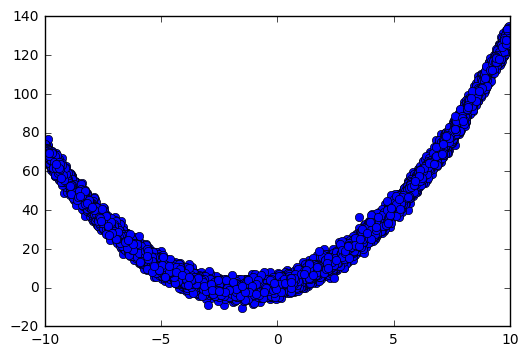

In [107]:
plt.plot(x,y,'o')

In [108]:
X = np.ndarray([num_points,2])
X[:,0] = x
X[:,1] = y

In [109]:
X.shape

(10000, 2)

# Laten space

In [110]:
z_size=10
def Z(batch_size,z_size=10):
    return np.random.uniform(-1.,1.,size=[batch_size,z_size])

# Miscellanous

In [111]:
batch_size = 100

# Linear discriminator

In [112]:
num_nodes_d = 100
g = tf.Graph()
with g.as_default():
    data_input = tf.placeholder(tf.float32,shape=[batch_size,2])
    
    W_d1 = tf.Variable(tf.truncated_normal([2,num_nodes_d]))
    b_d1 = tf.Variable(tf.zeros([num_nodes_d]))
    W_d2 = tf.Variable(tf.truncated_normal([num_nodes_d,1]))
    b_d2 = tf.Variable(tf.zeros([1]))
    
    d_vars = [W_d1,b_d1,W_d2,b_d2]
    def D(x,var_l):
        W1,b1 = var_l[0],var_l[1]
        W2,b2 = var_l[2],var_l[3]
        logit=tf.matmul(tf.sigmoid(tf.matmul(x,W1)+b1),W2)+b2
        return logit

# Linear generator

In [113]:
num_nodes_g=1000
with g.as_default():
    z_input = tf.placeholder(tf.float32,shape=[batch_size,z_size])
    
    W_g1 = tf.Variable(tf.truncated_normal([z_size,num_nodes_g]))
    b_g1 = tf.Variable(tf.zeros([num_nodes_g]))
    W_g2 = tf.Variable(tf.truncated_normal([num_nodes_g,num_nodes_g]))
    b_g2 = tf.Variable(tf.zeros([num_nodes_g]))
    W_g3 = tf.Variable(tf.truncated_normal([num_nodes_g,2]))
    b_g3 = tf.Variable(tf.zeros([2]))
    
    g_vars =[W_g1,b_g1,W_g2,b_g2,W_g3,b_g3]
    
    def G(z,var_l):
        W1,b1 = var_l[0],var_l[1]
        W2,b2 = var_l[2],var_l[3]
        W3,b3 = var_l[4],var_l[5]
        
        l1 = tf.sigmoid(tf.matmul(z,W1)+b1)
        l2 = tf.sigmoid(tf.matmul(l1,W2)+b2)
        g = tf.matmul(l2,W3)+b3
        
        return g

# Train

In [114]:
with g.as_default():
    D_data = D(data_input,d_vars)
    G_z = G(z_input,g_vars)
    D_g = D(G_z,d_vars)
    
    loss_d =-tf.reduce_mean(tf.log(tf.sigmoid(D_data)) +tf.log(1- tf.sigmoid(D_g)))
    loss_g = tf.reduce_mean(tf.log(1- tf.sigmoid(D_g)))
    
    opt = tf.train.AdamOptimizer(learning_rate=.0002,beta1=.5)
    
    train_d = opt.minimize(loss_d,var_list=d_vars)
    train_g = opt.minimize(loss_g,var_list=g_vars)

# Other ops

In [115]:
with g.as_default():
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Train Session

In [116]:
sess = tf.Session(graph = g)
sess.run(init)

In [117]:
epoch_size = X.shape[0]/batch_size

In [118]:
lossesd,lossesg = [],[]

In [119]:
num_epochs = 300
for _ in tqdm(range(num_epochs)):
    for s in range(epoch_size):
        fd = {data_input:X[s*batch_size:s*batch_size+batch_size,:],z_input:Z(batch_size,z_size)}
        ld,_=sess.run([loss_d,train_d],feed_dict=fd)
        lg,_=sess.run([loss_g,train_g],feed_dict=fd)
        lossesd.append(ld),lossesg.append(lg)

100%|██████████| 300/300 [01:21<00:00,  3.69it/s]


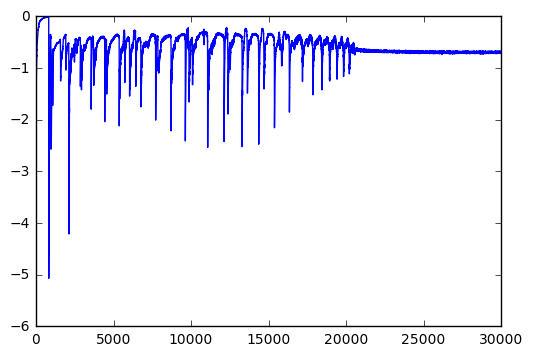

In [120]:
plt.plot(lossesg)

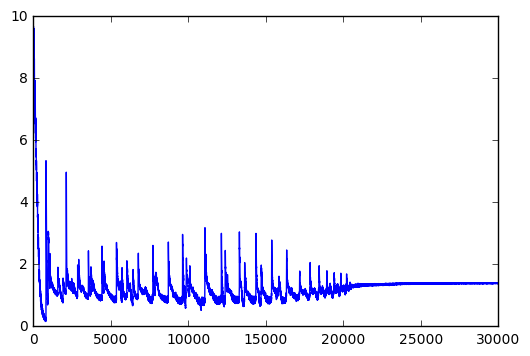

In [121]:
plt.plot(lossesd)

# Visualize

In [122]:
G_test=sess.run(G_z,feed_dict=fd)

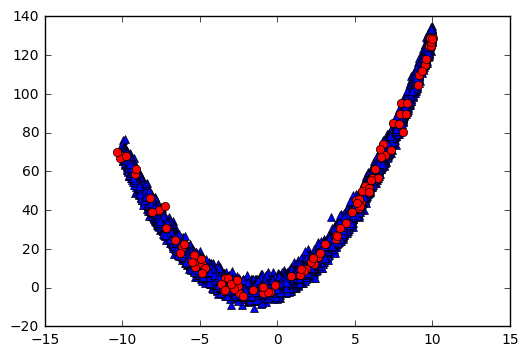

In [123]:
plt.plot(X[:,0],X[:,1],'b^',G_test[:,0],G_test[:,1],'ro')
# plt.savefig('images/img')